In this notebook I want to prepare i show some statistics to prove how statistic and probability can impact on trading models and strategies.

To simplify, I will use example of games with probability.

### "Zero-Edge Game" - Game of two players which play always with 0.5 win probability

**Assumptions**
- Both traders do a decision, buy or sell
- The market every day increase or decreasy by $1 everyday
- If trader buy and the price increase, they **win $1**, analogic for sell, if sell and price do down, they **win $1**
- If trader buy and the price decreasy, they **loss $1** analogic for sell

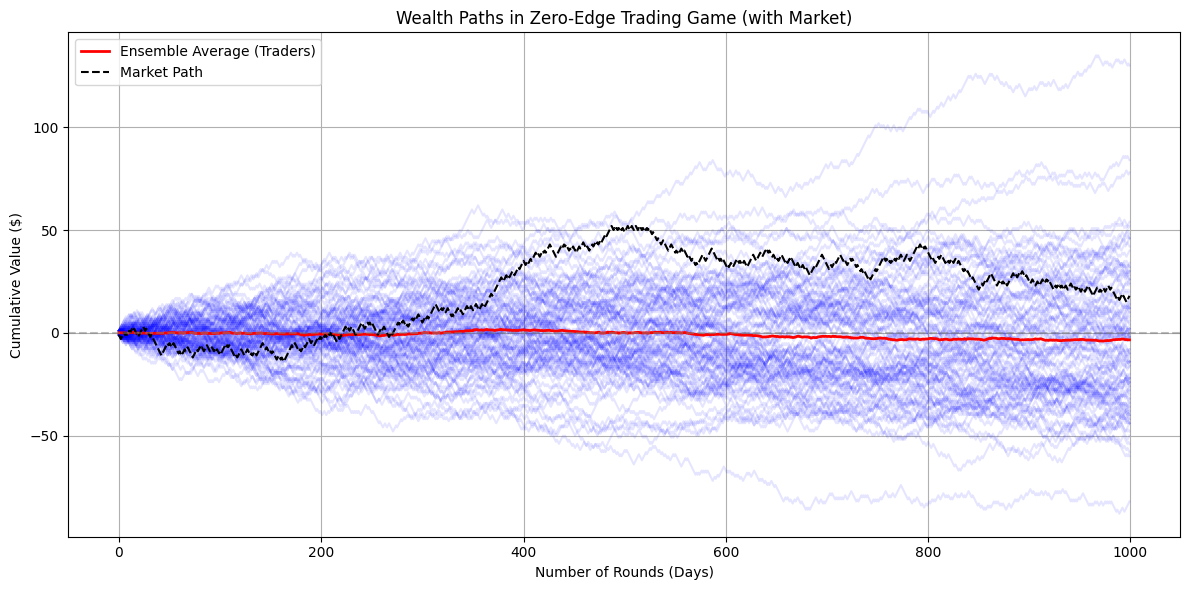

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# All decisions have binary character and have probablisisitc of 0.5
def zero_edge_game_binomial(rounds, n_traders=1):
    """Simulate Zero-Edge Game where traders buy/sell randomly and market moves randomly."""

    # Market moves: 1 (up), 0 (down) → convert to +1/-1
    market_raw = np.random.binomial(n=1, p=0.5, size=rounds) # return 0 or 1
    market_moves = 2 * market_raw - 1  # +1 = up, -1 = down

    # Trader decisions: 1 (buy), 0 (sell) → convert to +1/-1
    decision_raw = np.random.binomial(n=1, p=0.5, size=(n_traders, rounds))
    decisions = 2 * decision_raw - 1  # +1 = buy, -1 = sell

    # Outcome: profit if trader aligns with market direction
    outcomes = decisions * market_moves  # +1 = profit, -1 = loss

    # Cumulative wealth and market path
    wealth = np.cumsum(outcomes, axis=1)
    market_price = np.cumsum(market_moves)

    return wealth, market_price

# Parameters
n_rounds = 1000
n_traders = 100

# Run simulation
wealth_paths, market_price = zero_edge_game_binomial(n_rounds, n_traders)

# Plotting
plt.figure(figsize=(12, 6))

# Plot individual trader paths
for i in range(n_traders):
    plt.plot(wealth_paths[i], alpha=0.1, color='blue')

# Plot ensemble average
ensemble_avg = np.mean(wealth_paths, axis=0)
plt.plot(ensemble_avg, color='red', linewidth=2, label='Ensemble Average (Traders)')

# Plot market path
plt.plot(market_price, color='black', linestyle='--', linewidth=1.5, label='Market Path')

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.title('Wealth Paths in Zero-Edge Trading Game (with Market)')
plt.xlabel('Number of Rounds (Days)')
plt.ylabel('Cumulative Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Conclusions

This simulation represents 100 random traders making buy/sell decisions on a market that moves randomly (zero expected trend). Here's what we observe from the chart:

1. No Long-Term Edge (Mean Reverts to Zero)
- The red line (ensemble average) stays close to zero over the entire 1000-round period.
- This confirms the theoretical expectation: if traders have no edge (decisions are random), the average profit tends toward zero.
- There is no compounding advantage for any strategy purely based on randomness.

2. Individual Variability ≠ Skill
- Blue lines (individual trader wealth paths) vary widely.
- Some traders end up with significant profits or losses, but this is due to luck, not skill.
- The spread increases over time — variance grows, but the mean stays flat.

3. Market Drift Does Not Imply Profit
- The black dashed line shows cumulative market movement (price simulation).
- Although the market trended upward for some time (e.g., 200–500), the average trader didn’t profit from it.
- Because trader actions are random, they don't systematically align with the trend.

4. Trading = Zero-Sum Without Edge
- The experiment validates that **trading without informational or strategic edge is like gambling**.
- Over time, **the law of large numbers wins**: gains and losses balance out across all participants.

### Interpretation (for trading psychology / systems research)
This simple experiment illustrates:

- Why retail traders without a strategy lose in the long run.
- That variance is not proof of skill — even winning traders can be lucky.
- How important edge, discipline, or asymmetry is if you want to break out of randomness.

To eplore more:
- Efficient Market Hypothesis (EMH)
- Random Walk Theory
- Kelly Criterion or Risk of Ruin
- Or even Hurst exponent if you're tying into trend persistence.